In [1]:
import os
import json
import numpy as np
import pandas as pd

In [2]:
import re
import sys
import copy
import itertools
from scipy import stats

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib.ticker as ticker

In [5]:
sys.path.append(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(os.path.join(os.getcwd(), "..", "scripts"))

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
out_path = os.path.join("..", "derivatives", "TEMP")

# 1. Checking dataset

In [ ]:
from data_preparing import DataManager
from feature_engineering import FeatureReducer, FeatureSelector, BorutaSelector
from age_pred_model import (
    Constants, Config, 
    convert_np_types, initialization, filter_features_preliminary, prepare_dataset, divide_and_preprocess_data
)

In [ ]:
sys.argv = ['']
args, constants, config, logger = initialization()

In [ ]:
# print(config.raw_data_path)

In [ ]:
# raw_data = pd.read_csv(config.raw_data_path)
# raw_data.shape

In [ ]:
DF_prepared = prepare_dataset(args, constants, config, logger)
DF_prepared.shape

In [ ]:
preprocessed_data_dicts = divide_and_preprocess_data(DF_prepared, args, config, logger)

In [ ]:
# ages = DF_prepared["BASIC_INFO_AGE"]
# print(min(ages), max(ages))

In [ ]:
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(6, 2))
dat_1 = DF_prepared.query("BASIC_INFO_SEX == 1")["BASIC_INFO_AGE"]
dat_2 = DF_prepared.query("BASIC_INFO_SEX == 2")["BASIC_INFO_AGE"]
ax.hist(
    [dat_1, dat_2], 
    bins=np.linspace(19, 80, 61), rwidth=1, histtype='bar', 
    color=['#3399FF', '#FF9933'], # histtype='stepfilled', alpha=0.6, 
    label=[f"M", f"F"]
    # label=[f"Male (N = {len(dat_1)})", f"Female (N = {len(dat_2)})"]
)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.tick_params(axis="both", which="major", labelsize=12)
ax.legend(loc=["upper left", "upper right"][1])
plt.tight_layout()
plt.savefig(os.path.join(out_path, "Age distributions.png"), dpi=500)

## 1-2. Plot feature sunbursts 

In [ ]:
# from gen_derivatives import make_feature_DF, ColorDicts
# from plotting import plot_feature_sunburst

In [ ]:
# color_dicts = ColorDicts()

In [ ]:
# domain_approach_mapping = { 
#     "STRUCTURE": {
#         "domains": ["STRUCTURE"],
#         "approaches": ["MRI"]
#     },
#     "BEH": {
#         "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
#         "approaches": ["BEH"]
#     },
#     "FUNCTIONAL": {
#         "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
#         "approaches": ["EEG", "MRI"]
#     }, 
#     "ALL": {
#         "domains": ["STRUCTURE", "MOTOR", "MEMORY", "LANGUAGE"], 
#         "approaches": ["MRI", "BEH", "EEG"]
#     }
# }

In [ ]:
# for ori_name, ori_content in domain_approach_mapping.items():
    
#     DF_filtered = filter_features_preliminary(
#         DF_prepared, 
#         domains=ori_content["domains"], 
#         approaches=ori_content["approaches"] , 
#         ori_name=ori_name
#     )
#     feature_list = DF_filtered.columns
#     feature_DF = make_feature_DF(ori_name, feature_list, None)
    
#     plot_feature_sunburst(
#         feature_DF_dict=feature_DF, 
#         parent_col="approach_and_num", 
#         label_col="domain_and_num", 
#         color_dict=color_dicts.sunburst[ori_name], 
#         one_or_many="one", 
#         fig_title=ori_name[:3], 
#         output_path=os.path.join(out_path, f"2025-10-23 feature_sunburst ({ori_name[:3]}).png"), 
#         overwrite=True
#     )

# 2. Plotting results

In [8]:
from gen_derivatives import (
    Constants, Description, load_model_results, force_agesex_cols
)
from plotting import (
    plot_categorical_bars, plot_bars_with_stats, plot_cormat, plot_color_legend
)

In [9]:
const = Constants()

In [10]:
from compare_versions import (
    Config, define_arguments, compare_pad_values
)

In [11]:
sys.argv = [
    'compare_versions.py', 
    '-v', '0', 
    '-ba', '2025-09-17_original_sex-0_XGBM', 
    '-un', '2025-09-17_original_age-0_sex-0_XGBM', 
    '-n', 'Original data (testing set), XGBM model, no feature selection or reduction', 
    '-p', 'original_XGBM', 
    '-cbg', '0'
]
args = define_arguments()
custom_bar_x_lab = ["AgeGroup", "AgeSex"][args.custom_bar_x_lab] if args.custom_bar_x_lab is not None else None
config = Config(args)

In [12]:
version_list = list(config.input_folders.keys())
color_dict = dict(zip(version_list, sns.color_palette("husl", len(version_list))))

## 2-0. Loading results

In [13]:
result_DF_list = []
args.ignore_all = False

for version, input_folder in config.input_folders.items():
    desc_json_path = os.path.join(input_folder, "description.json")
    with open(desc_json_path, 'r', errors='ignore') as f:
        desc_json = json.load(f)
    desc = Description(desc_json, const, args)

    config.result_path = os.path.join(input_folder, "results_{}_{}.json")
    result_DF, _, _ = load_model_results(
        config, desc, const, 
        output_path=os.path.join(out_path, f"results_DF_{version}.csv"), 
        overwrite=args.overwrite
    )
    result_DF["Version"] = version
    result_DF["VerType"] = result_DF["Version"] + "_" + result_DF["Type"]

    result_DF.rename(columns={"PredictedAgeDifference": "PAD", "CorrectedPAD": "PADAC",}, inplace=True)
    result_DF["PAD_abs"] = result_DF["PAD"].abs()
    result_DF["PADAC_abs"] = result_DF["PADAC"].abs()

    if args.custom_bar_x_lab is not None:
        data_DF = pd.read_csv(config.raw_data_path)
        data_DF["SID"] = data_DF["BASIC_INFO_ID"].map(lambda x: x.replace("sub-0", ""))
        temp_DF = force_agesex_cols(DF=result_DF, DF2=data_DF)
        temp_DF.rename(columns={custom_bar_x_lab: "BarGroup"}, inplace=True)
        result_DF = pd.merge(
            result_DF, temp_DF.loc[:, ["SID", "BarGroup"]], on="SID", how="left"
        )
            
    if "Sex" not in result_DF.columns:
        result_DF["Sex"] = ""
        result_DF.replace({"AgeGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
    else:
        result_DF.replace({"AgeGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
    
    result_DF["Group"] = result_DF["AgeGroup"] + result_DF["Sex"]
    result_DF_list.append(result_DF)

final_result_DF = pd.concat(result_DF_list, ignore_index=True)
final_result_DF.drop_duplicates(inplace=True)

Loading results_le-44_STRUCTURE.json ...
Loading results_le-44_BEH.json ...
Loading results_le-44_FUNCTIONAL.json ...
Loading results_le-44_ALL.json ...
Loading results_ge-45_STRUCTURE.json ...
Loading results_ge-45_BEH.json ...
Loading results_ge-45_FUNCTIONAL.json ...
Loading results_ge-45_ALL.json ...
Loading results_all_STRUCTURE.json ...
Loading results_all_BEH.json ...
Loading results_all_FUNCTIONAL.json ...
Loading results_all_ALL.json ...


In [14]:
final_result_DF.head()

,Type,SID,Model,AgeGroup,Age,PredictedAge,PAD,PADAC,CorrectedPredictedAge,NumberOfFeatures,Version,VerType,PAD_abs,PADAC_abs,BarGroup,Sex,Group
0,STR,001,XGBM,Y,41,32.448372,-8.551628,-6.479589,34.520411,680,ByAge,ByAge_STR,8.551628,6.479589,Y,,Y
4,STR,002,XGBM,Y,26,24.413649,-1.586351,0.170675,26.170675,680,ByAge,ByAge_STR,1.586351,0.170675,Y,,Y
8,STR,008,XGBM,Y,28,29.935770,1.935770,1.120563,29.120563,680,ByAge,ByAge_STR,1.935770,1.120563,Y,,Y
12,STR,023,XGBM,Y,31,29.060505,-1.939495,-1.221679,29.778321,680,ByAge,ByAge_STR,1.939495,1.221679,Y,,Y
16,STR,029,XGBM,Y,22,28.296892,6.296892,4.528328,26.528328,680,ByAge,ByAge_STR,6.296892,4.528328,Y,,Y


In [15]:
stats_DF_dict = {}
feature_orientations = final_result_DF["Type"].unique()

for pad_type in ["PAD", "PADAC"]:
    stats_DF_list = []
    
    for ori_name in feature_orientations:
        for group in ["Y", "O"]:
            for ver_1, ver_2 in itertools.combinations(version_list, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Type", ori_name)
                stats_results.insert(1, "Group", group)
                stats_results.insert(2, "V1", ver_1)
                stats_results.insert(3, "V2", ver_2)
                stats_DF_list.append(stats_results)
    
    stats_DF = pd.concat(stats_DF_list, ignore_index=True)
    stats_DF_dict[pad_type] = stats_DF

## 2-1. PAD/PADAC bars

### 2-1-1. Test if an age-stratified approach improves prediction accuracy

In [16]:
temp_result_DF = (
    final_result_DF
    .loc[:, ["Version", "Type", "BarGroup", "SID", "PAD_abs", "PADAC_abs"]]
    .melt(id_vars=["Version", "Type", "BarGroup", "SID"], 
          value_vars=["PAD_abs", "PADAC_abs"], 
          var_name="var")
)
temp_result_DF["NewGroup"] = temp_result_DF["BarGroup"].astype(str) + "_" + temp_result_DF["var"]

In [17]:
temp_stats_DF_1 = stats_DF_dict["PAD"].copy(deep=True)
temp_stats_DF_1.insert(0, "var", "PAD")
temp_stats_DF_2 = stats_DF_dict["PADAC"].copy(deep=True)
temp_stats_DF_2.insert(0, "var", "PADAC")
temp_stats_DF = pd.concat(
    [temp_stats_DF_1, temp_stats_DF_2], 
    ignore_index=True
)

In [32]:
temp_stats_DF.head(1)

,var,Type,Group,V1,V2,V1_mean,V2_mean,V1_std,V2_std,Cohen_d,Levene_stat,Levene_p,Equal_var,DF,T_stat,P_value,P_sig,NewGroup
0,PAD,STR,Y,ByAge,Undivided,3.785977,7.066285,2.538892,4.925348,-0.837192,14.681334,0.000216,F,53,-4.651762,0.000022,***,Y_PAD


In [18]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})

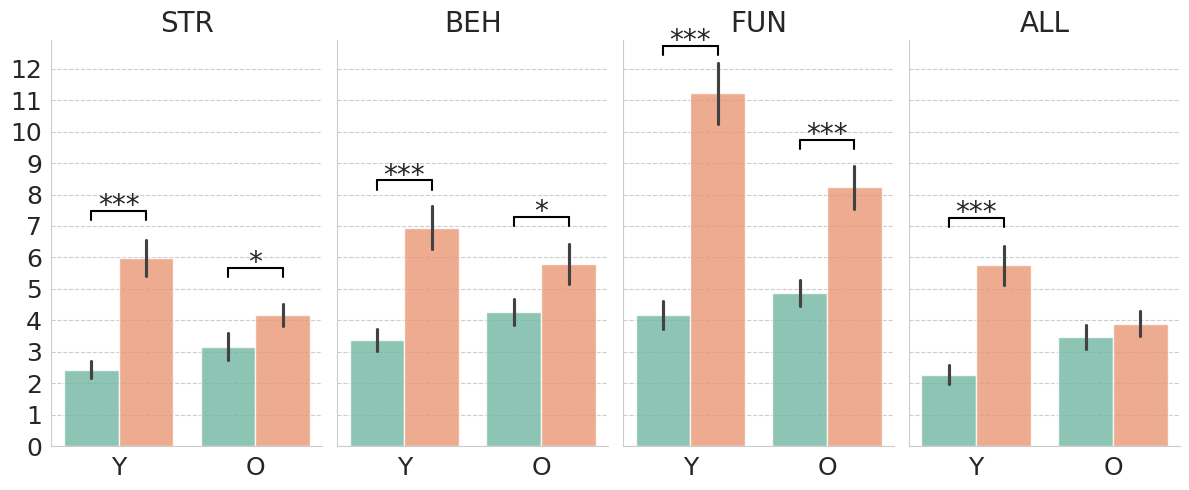

In [38]:
pad_type = ["PAD", "PADAC"][1]

g = sns.catplot(
    data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
    x="BarGroup", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
    hue="Version", palette=sns.color_palette("Set2", 2), 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    sub_stats_DF = temp_stats_DF.query(f"var == '{pad_type}' & Type == '{col_val}'")
    
    for group, x_pos in zip(["Y", "O"], [0, 1]):
        stats_res = sub_stats_DF.query(f"Group == '{group}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
        # p_sig = "< .001 ***" if p_val < .001 else f"{p_val:.3f} {p_sig}"
        y_pos = max([stats_res["V1_mean"].max(), stats_res["V2_mean"].max()]) + 1.5
        
        if p_val < .05:
            ax.plot( [x_pos-.2, x_pos+.2], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos-.2, x_pos-.2], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.plot( [x_pos+.2, x_pos+.2], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.text(x_pos, y_pos-.3, p_sig, 
                    ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 12.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-11-06 compare_PADAC_bars.png"))

In [ ]:
# pad_type = ["PAD", "PADAC"][1]
# color_dict = dict(zip(["Y", "O"], sns.color_palette("Set2", 2)))

# g = sns.catplot(
#     data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
#     x="Version", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
#     hue="BarGroup", hue_order=["Y", "O"], palette=color_dict, 
#     height=5, aspect=.6, alpha=.8, legend=None
# )

# for col_val, ax in g.axes_dict.items():
#     sub_stats_DF = temp_stats_DF.query(f"var == '{pad_type}' & Type == '{col_val}'")
#     y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .5
    
#     for group, x_pos in zip(["Y", "O"], [-.2, .2]):
#         stats_res = sub_stats_DF.query(f"Group == '{group}'")
#         p_val = stats_res.iloc[0]["P_value"]
#         p_sig = stats_res.iloc[0]["P_sig"]
#         # p_sig = "< .001 ***" if p_val < .001 else f"{p_val:.3f} {p_sig}"
        
#         if p_val < .05:
#             y_pos += 1 # offset
#             ax.plot( [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5)
#             ax.plot( [x_pos, x_pos], [y_pos, y_pos-.3], color="k", lw=1.5)
#             ax.plot( [x_pos+1, x_pos+1], [y_pos, y_pos-.3], color="k", lw=1.5)
#             ax.text((x_pos+.5), y_pos-.4, p_sig, 
#                     ha="center", va="bottom", fontsize=19, fontdict={"style": "italic"})
    
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.set_title(col_val, fontsize=20)
#     ax.tick_params(axis="both", which="major", labelsize=18)
    
# g.set(ylim=(0, 14.9))
# g.set_xlabels("")
# g.set_ylabels("")
# g.figure.tight_layout()
# g.figure.savefig(os.path.join(out_path, f"2025-11-06 compare_PADAC_bars.png"))

#### PAD and PADAC in same plot

In [ ]:
temp_stats_DF["NewGroup"] = temp_stats_DF["Group"] + "_" + temp_stats_DF["var"]

In [ ]:
color_list = ["#E1712B", "#FE9A37", "#2A9689", "#36BBA7"]
hatches = itertools.cycle(['', '//'])

g = sns.catplot(
    data=temp_result_DF, 
    x="Version", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
    hue="NewGroup", hue_order=["Y_PAD_abs", "Y_PADAC_abs", "O_PAD_abs", "O_PADAC_abs"], palette=color_list, 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    sub_stats_DF = temp_stats_DF.query(f"Type == '{col_val}'")
    y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .7
    
    for group, x_pos in zip(["Y_PAD", "Y_PADAC", "O_PAD", "O_PADAC"], np.linspace(-.3, .3, 4)):
        stats_res = sub_stats_DF.query(f"NewGroup == '{group}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
        
        if p_val < .05:
            y_pos += 1 # offset
            ax.plot( [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos, x_pos], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.plot( [x_pos+1, x_pos+1], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.text((x_pos+.5), y_pos-.5, p_sig, 
                    ha="center", va="bottom", fontsize=19, fontdict={"style": "italic"})
            
    for i, bar in enumerate(ax.patches):
        if i % 2 == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 17.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars.png"))

### 2-1-2. Compare models trained using features in specific modalities

In [ ]:
stats_DF_list = []

for version in ["ByAge", "Undivided"]:
    for group in ["Y", "O"]:
        for pad_type in ["PAD", "PADAC"]:
            for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Version", version)
                stats_results.insert(1, "Group", group)
                stats_results.insert(2, "PAD_type", pad_type)
                stats_results.insert(3, "V1", ori_1)
                stats_results.insert(4, "V2", ori_2)
                stats_DF_list.append(stats_results)
                
new_stats_DF = pd.concat(stats_DF_list, ignore_index=True)

In [ ]:
temp_result_DF.head(1)

In [ ]:
temp_result_DF["NewGroup2"] = temp_result_DF["Version"] + "_" + temp_result_DF["BarGroup"].astype(str)

In [ ]:
my_palette = [
    list(sns.color_palette("husl", 5))[0], 
    list(sns.color_palette("husl", 5))[1], 
    list(sns.color_palette("husl", 5))[3], 
    list(sns.color_palette("husl", 5))[4]
]

In [ ]:
pad_type = ["PAD", "PADAC"][1]

g = sns.catplot(
    data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
    x="Type", y="value", col="NewGroup2", kind="bar", errorbar="se", sharex=False, 
    hue="Type", hue_order=["STR", "BEH", "FUN", "ALL"], palette=my_palette, 
    height=5, aspect=.6, alpha=.8, legend=None
)

x_pos_dict = dict(zip(feature_orientations, range(4)))

for col_val, ax in g.axes_dict.items():
    version, group = col_val.split("_")
    sub_stats_DF = new_stats_DF.query(f"Version == '{version}' & Group == '{group}' & PAD_type == '{pad_type}'")
    y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .5

    for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
        stats_res = sub_stats_DF.query(f"V1 == '{ori_1}' & V2 == '{ori_2}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
            
        if p_val < .05:
            x_pos_1 = x_pos_dict[ori_1]
            x_pos_2 = x_pos_dict[ori_2]
            y_pos += 1.1 # offset
            ax.plot( [x_pos_1, x_pos_2], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos_1, x_pos_1], [y_pos, y_pos-.2], color="k", lw=1.5)
            ax.plot( [x_pos_2, x_pos_2], [y_pos, y_pos-.2], color="k", lw=1.5)
            ax.text(np.mean([x_pos_1, x_pos_2]), y_pos-.5, p_sig, 
                    ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 15.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-11-05 compare_PADAC_bars (2).png"))

#### PAD and PADAC in same plot

In [ ]:
# temp_result_DF["var"] = temp_result_DF["var"].map({"PAD_abs": "original", "PADAC_abs": "corrected"})

In [ ]:
# g = sns.catplot(
#     data=temp_result_DF, 
#     x="var", y="value", col="NewGroup2", kind="bar", errorbar="se", sharex=False, 
#     hue="Type", hue_order=["STR", "BEH", "FUN", "ALL"], palette=sns.color_palette("husl", 4), 
#     height=5, aspect=.6, alpha=.8, legend=None
# )

# x_pos_dict = {
#     "PAD": dict(zip(feature_orientations, np.linspace(-.3, .3, 4))), 
#     "PADAC": dict(zip(feature_orientations, np.linspace(-.3, .3, 4) + 1))
# }
# for col_val, ax in g.axes_dict.items():
#     version, group = col_val.split("_")

#     for pad_type in ["PAD", "PADAC"]: 
#         sub_stats_DF = new_stats_DF.query(f"Version == '{version}' & Group == '{group}' & PAD_type == '{pad_type}'")
#         y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()])

#         for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
#             stats_res = sub_stats_DF.query(f"V1 == '{ori_1}' & V2 == '{ori_2}'")
#             p_val = stats_res.iloc[0]["P_value"]
#             p_sig = stats_res.iloc[0]["P_sig"]
            
#             if p_val < .05:
#                 x_pos_1 = x_pos_dict[pad_type][ori_1]
#                 x_pos_2 = x_pos_dict[pad_type][ori_2]
#                 y_pos += 2.5 # offset
#                 ax.plot( [x_pos_1, x_pos_2], [y_pos, y_pos], color="k", lw=1.5)
#                 ax.plot( [x_pos_1, x_pos_1], [y_pos, y_pos-.3], color="k", lw=1.5)
#                 ax.plot( [x_pos_2, x_pos_2], [y_pos, y_pos-.5], color="k", lw=1.5)
#                 ax.text(np.mean([x_pos_1, x_pos_2]), y_pos-.5, p_sig, 
#                         ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})

#     for i, bar in enumerate(ax.patches):
#         if i % 2 == 1:
#             bar.set_hatch('//')
    
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#     ax.set_title(col_val, fontsize=20)
#     ax.tick_params(axis="both", which="major", labelsize=18)
    
# g.set(ylim=(0, 23))
# g.figure.tight_layout()
# g.set_xlabels("")
# g.set_ylabels("")
# g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars (2).png"))

## 2-2. Correlation matrices

In [39]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

In [40]:
from utils import basic_Q_features, ST_features
basic_q_features = basic_Q_features()
st_features = ST_features()

In [41]:
sub_DF_Y = final_result_DF.query("Version == 'ByAge' & AgeGroup == 'Y'")
sub_DF_O = final_result_DF.query("Version == 'ByAge' & AgeGroup == 'O'")
sub_DF_Un = final_result_DF.query("Version == 'Undivided'")
data_DF_interested = data_DF.loc[:, ["SID"] + basic_q_features + st_features]

In [42]:
sub_df_dict = {}

for pad_type in ["PAD", "PADAC"]:
    sub_df_dict[pad_type] = {}
    
    for group_name, sub_df in zip(["Y", "O", "Un"], [sub_DF_Y, sub_DF_O, sub_DF_Un]):
        sub_df = (
            sub_df.loc[:, ["Type", "SID", pad_type]]
            .pivot(index="SID", columns="Type", values=pad_type)
            .reset_index()
            .rename(columns={"index": "SID"})
        )
        sub_df_dict[pad_type][group_name] = sub_df.merge(data_DF_interested, on="SID", how="left")

### 2-2-1. Among PAC(AC) values

In [ ]:
for pad_type in ["PAD", "PADAC"]:
    for group_name in ["Y", "O", "Un"]:
        targ_df = sub_df_dict[pad_type][group_name].loc[:, sorted(desc.feature_oris)]
        cormat = targ_df.corr()
        mask = np.zeros_like(cormat)
        mask[np.triu_indices_from(mask)] = True
        
        sns.set_theme(style='white', font_scale=1.2)
        plt.figure(figsize=(4, 3), dpi=200)
        g = sns.heatmap(
            cormat, mask=mask, # square=True, 
            vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
            annot=True, fmt = ".2f", annot_kws={"size": 16}, 
        )
        plt.tight_layout()
        # plt.savefig(os.path.join(out_path, f"2025-11-05 {pad_type} cormat ({group_name}).png"))
        # plt.close()

### 2-2-2. Between PAD(AC) and standardized test or questionnaire

In [43]:
def create_annot_mat(cormat, p_stacked, fdr=0.05):
    q_vals = fdrcorrection(p_stacked.dropna().values, alpha=fdr)[1]
    q_stacked = pd.Series(q_vals, index=p_stacked.index)
    q_mat = q_stacked.unstack()
    # q_sig = q_mat.map(lambda x: "*" * sum( x <= t for t in [0.05, 0.01, 0.001] ))
    # annot_mat = cormat.map(lambda x: f"{x:.2f}") + q_sig.reindex_like(cormat)
    q_mask = q_mat < .05
    annot_mat = cormat.map(lambda x: f"{x:.2f}") * q_mask.reindex_like(cormat)
    return annot_mat.fillna("--")

In [44]:
basic_q_names = [
    "Edinburgh Handedness Inventory, Sum", 
    "Physical Function", 
    "Physical Limit", 
    "Emotional Well", 
    "Emotional Limit", 
    "Energy", 
    "Social Function", 
    "Pain", 
    "General Health", 
    "Physical", 
    "Mental", 
    "Sleep Quality", 
    "Sleep Latency", 
    "Sleep Duration", 
    "Sleep Efficiency", 
    "Sleep Disturbance", 
    "Sleep Medication", 
    "Daytime Dysfunction", 
    "Sum", 
    "IPAQ, Metabolic Equivalent of Task", 
    "Extraversion", 
    "Agreeableness", 
    "Conscientiousness", 
    "Emotional Stability", 
    "Intellect", 
    "Multidimensional Scale of Perceived Social Support, Sum", 
    "Cognitive Failure Scale, Sum", 
    "Anxiety", 
    "Depression", 
    "Montreal Cognitive Assessment, Sum" 
]

In [45]:
st_names = [
    "Similarity", 
    "Vocabulary", 
    "Information", 
    "Auditory Immediate", 
    "Visual Immediate", 
    "Working Memory", 
    "Logical Memory 1", 
    "Facial Memory 1", 
    "Verbal Pair 1", 
    "Family Picture 1", 
    "Letter Number Sequence", 
    "Spatial Forward", 
    "Spatial Backward", 
    "Fine Motor", 
    "Balance", 
    "Processing Speed" 
]

In [ ]:
# x_cols = sorted(desc.feature_oris)

# pad_type = ["PAD", "PADAC"][1]
# # for pad_type in ["PAD", "PADAC"]:

# for y_title, y_names, y_cols, fig_size in zip(
#     ["questionnaire", "standardized test"], 
#     [basic_q_names, st_names], 
#     [basic_q_features, st_features], 
#     [(12, 11), (8, 7)]
# ):
#     for group_name in ["Y", "O", "Un"]:
#         sub_df = sub_df_dict[pad_type][group_name]
#         cormat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
#         p_mat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=str)
#         for t1 in y_cols:
#             for t2 in x_cols:
#                 targ_df = sub_df[[t1, t2]].dropna()
#                 cormat.loc[t1, t2], p_mat.loc[t1, t2] = pearsonr(targ_df[t1], targ_df[t2])
#         p_stacked = p_mat.stack()
#         annot_mat = create_annot_mat(cormat, p_stacked)
#         mask = None
        
#         sns.set_theme(style='white', font_scale=1.1)
#         plt.figure(figsize=fig_size, dpi=200)
#         g = sns.heatmap(
#             cormat, mask=mask, square=False, 
#             vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
#             # cbar=True, cbar_kws={"shrink": 0.5, "label": "$r$"}, 
#             annot=pd.DataFrame(annot_mat), fmt = "", annot_kws={"size": 18}, 
#             xticklabels=x_cols, yticklabels=y_names
#         )
#         g.set(xlabel="", ylabel="")
#         g.tick_params(axis="both", which="major", labelsize=20)
#         plt.tight_layout()
#         plt.savefig(os.path.join(out_path, f"2025-11-06 {pad_type} corwith {y_title} features ({group_name}).png"))
#         plt.close()

In [47]:
# plt.figure(figsize=(2, 9))
# plt.imshow(np.array([[-1, 1]]), cmap="RdBu_r")
# plt.gca().set_visible(False)
# plt.colorbar(orientation="vertical")
# plt.tight_layout()
# # plt.savefig(os.path.join(out_path, "colorbar.jpg"))
# plt.close()

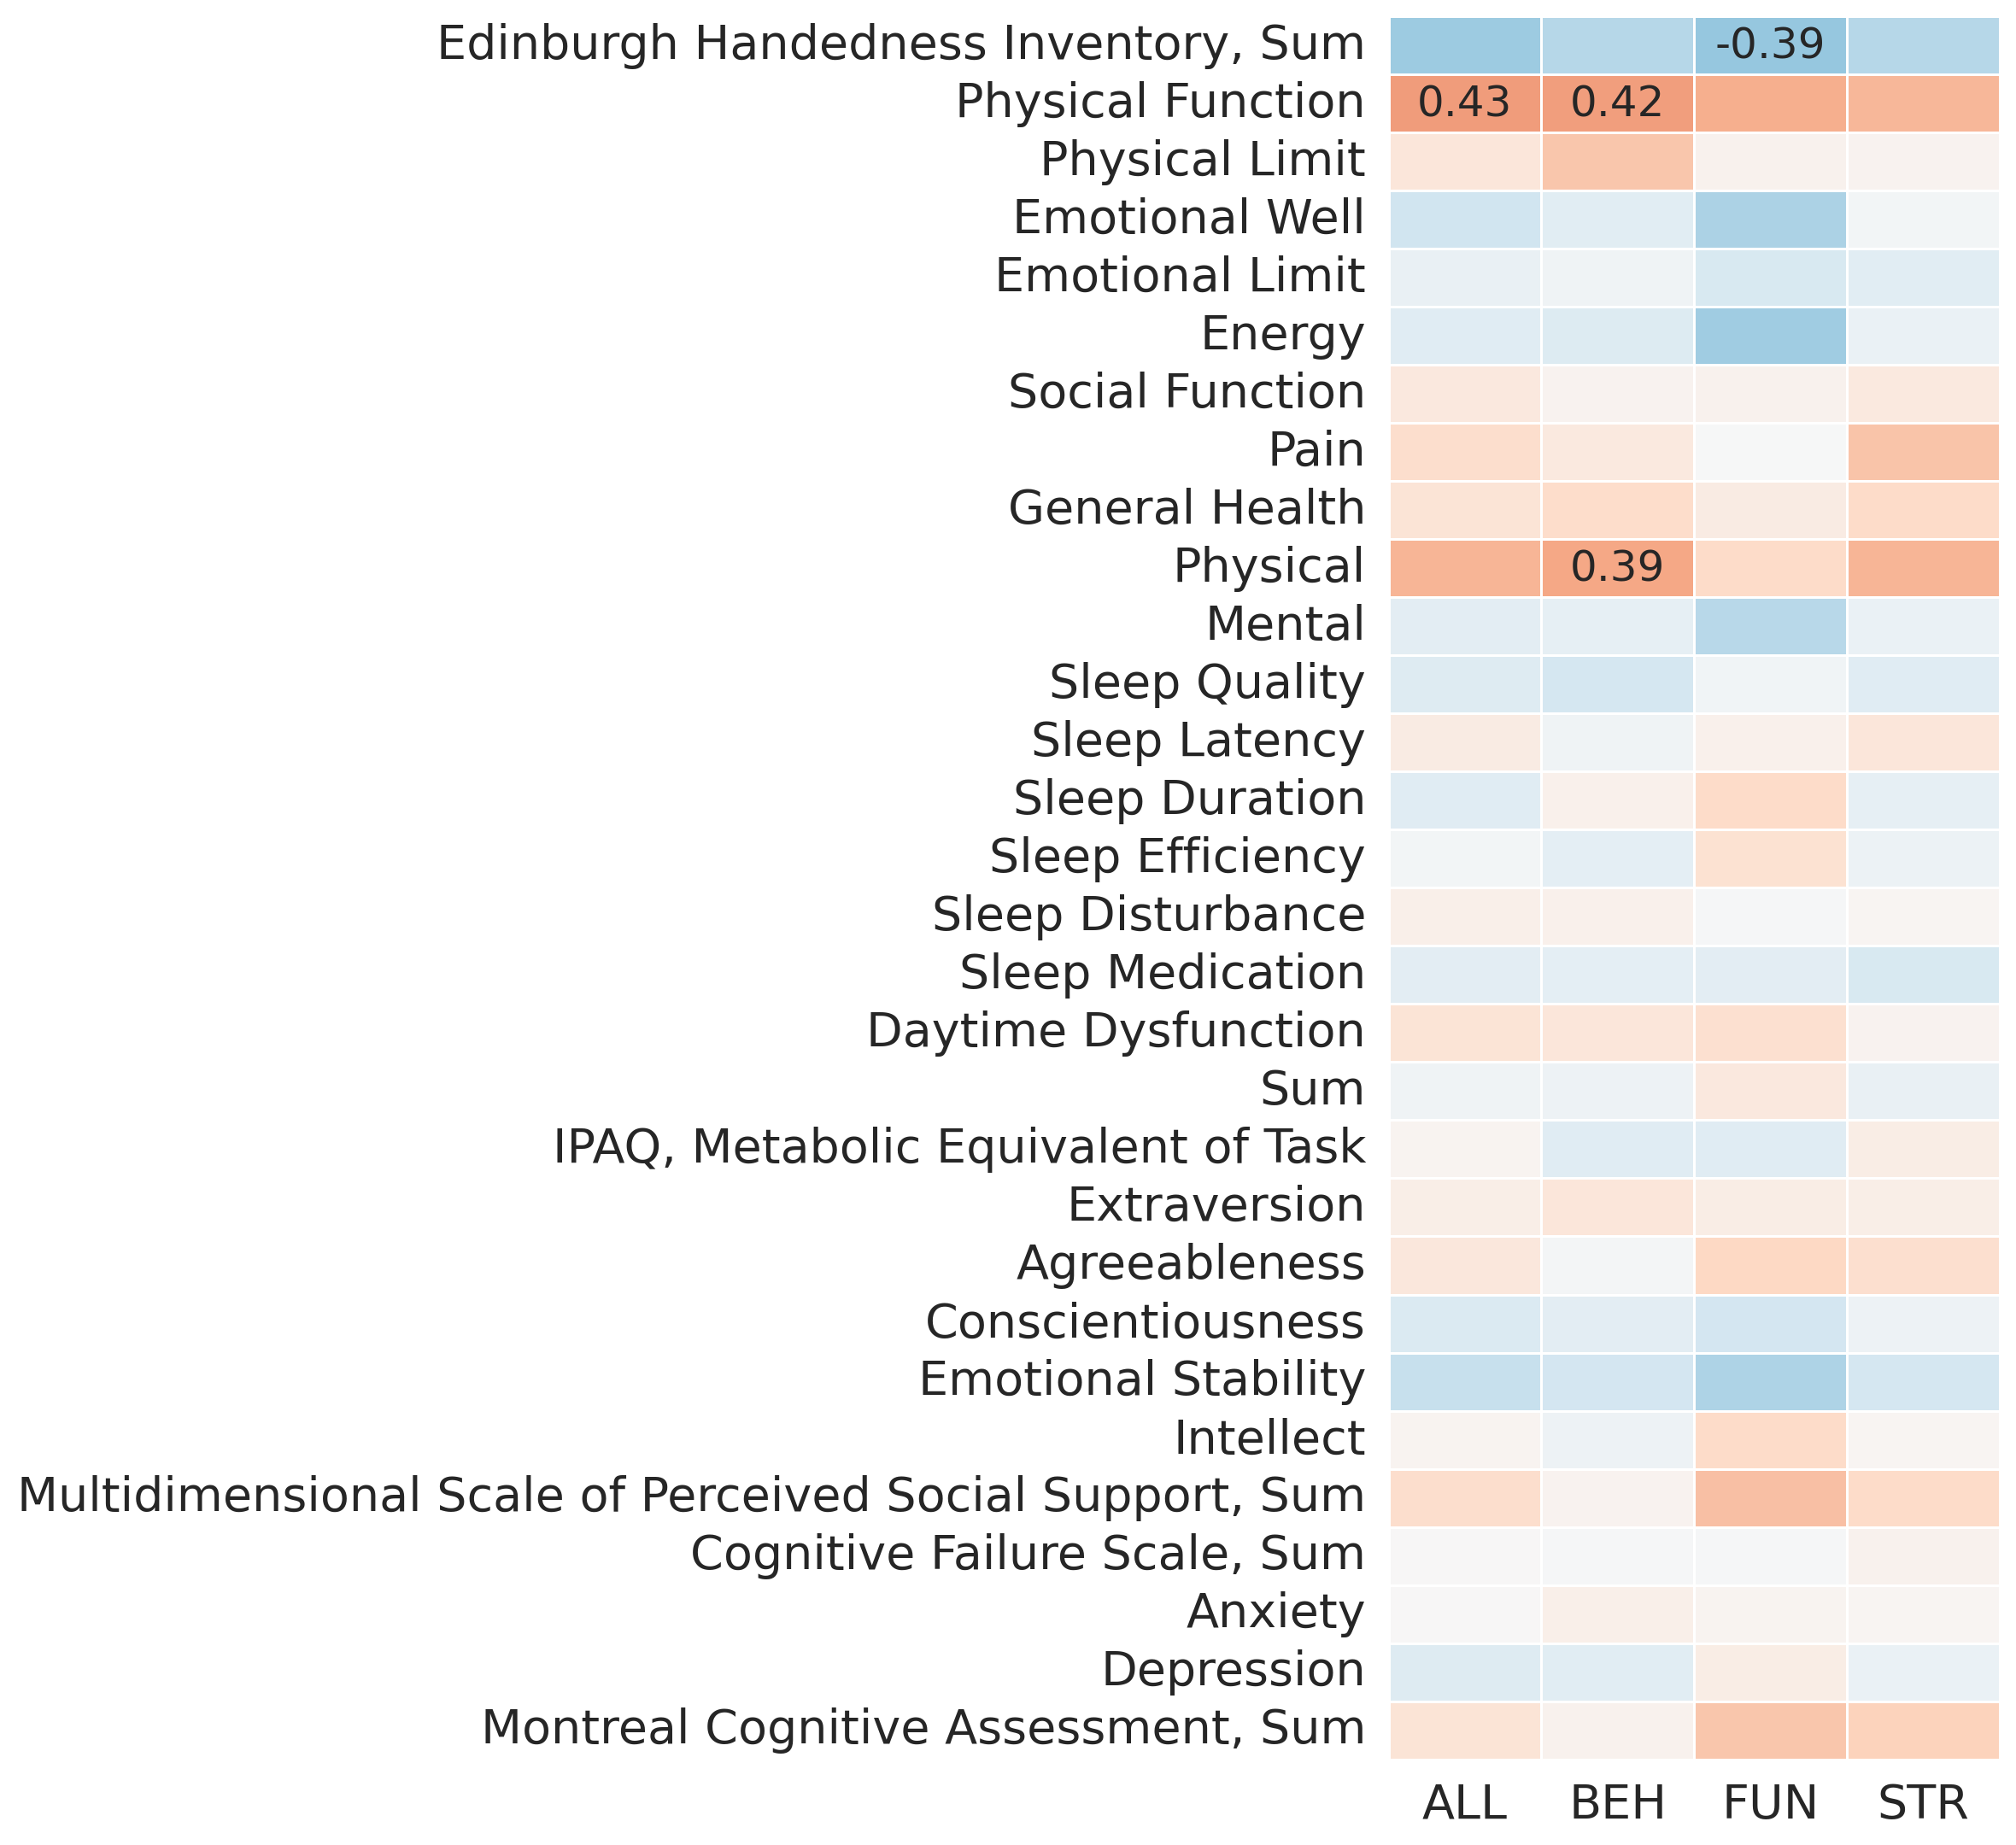

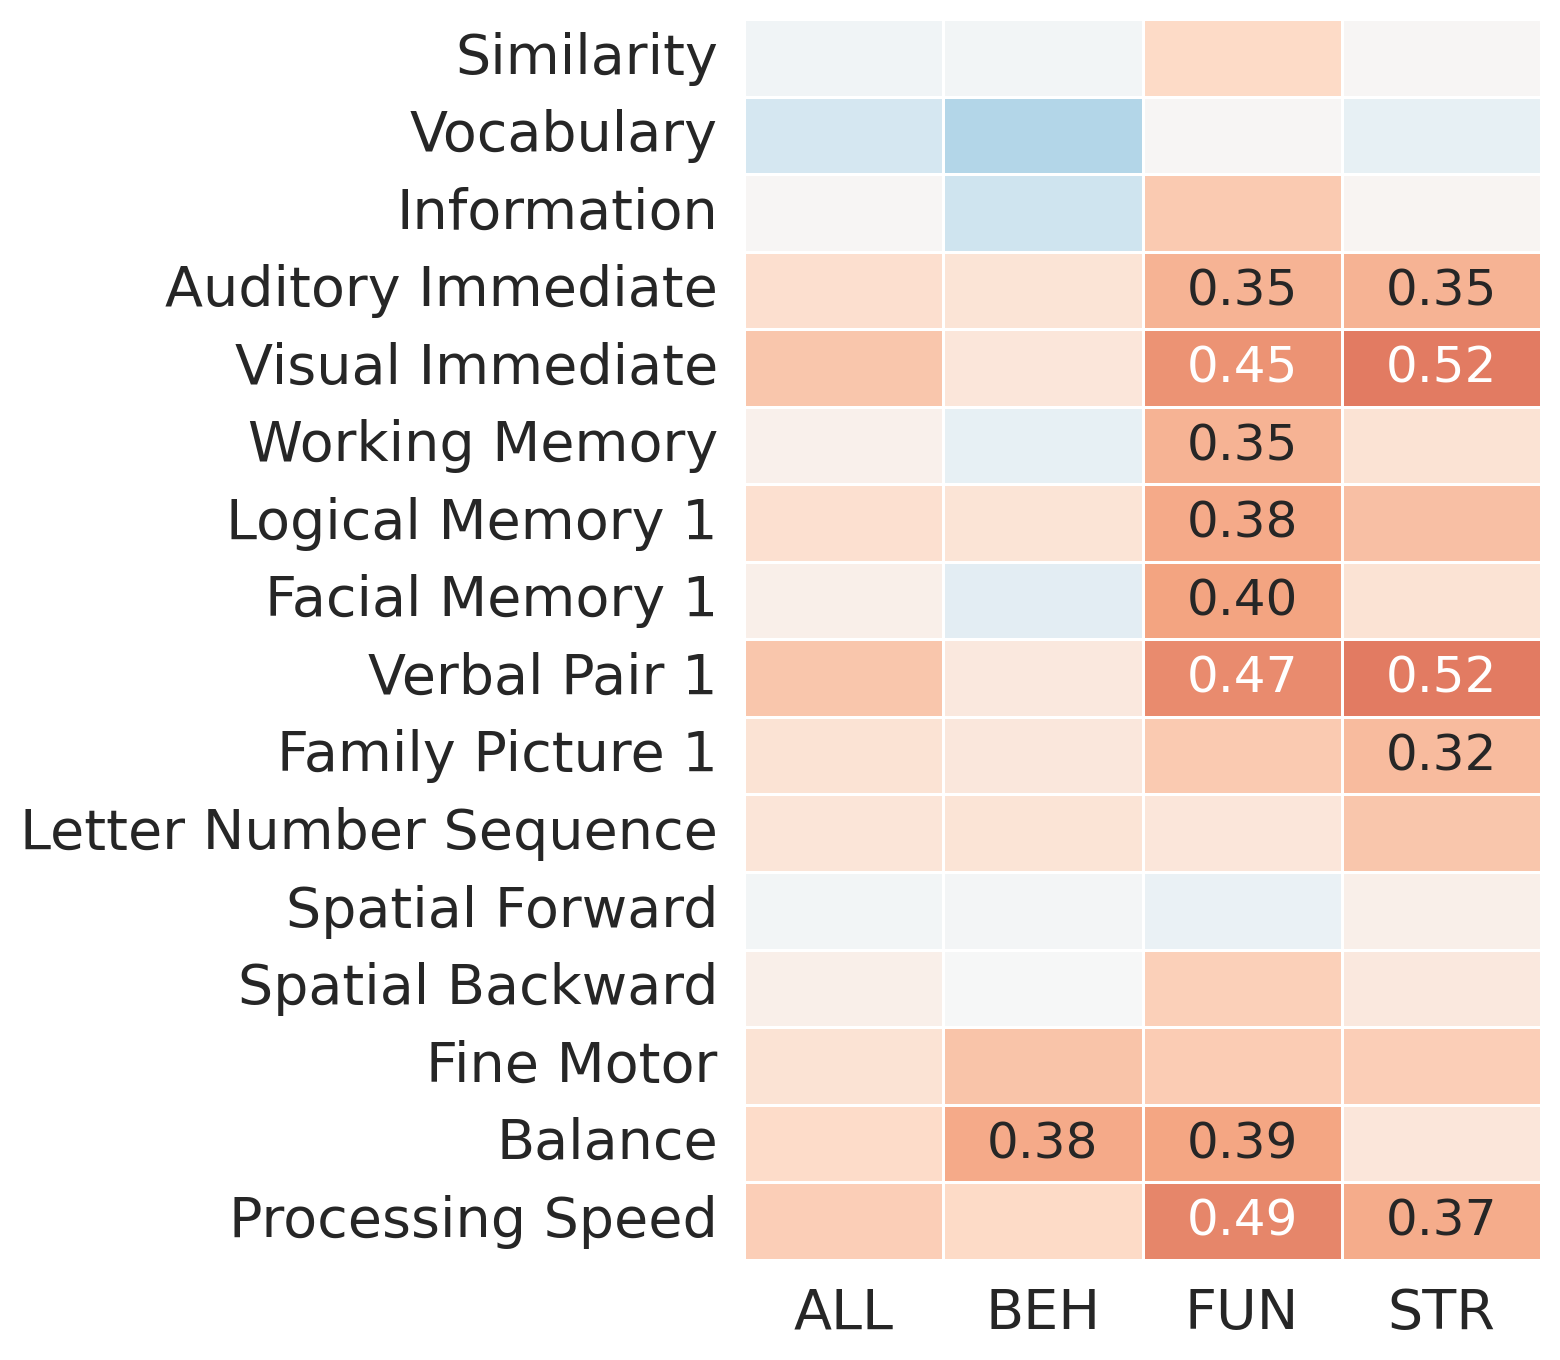

In [63]:
seed = np.random.randint(0, 10000)
N = 64

x_cols = sorted(desc.feature_oris)

pad_type = ["PAD", "PADAC"][1]
group_name = ["Y", "O", "Un"][2]

for y_title, y_names, y_cols, fig_size in zip(
    ["questionnaire", "standardized test"], 
    [basic_q_names, st_names], 
    [basic_q_features, st_features], 
    [(12, 11), (8, 7)]
):
    sub_df = sub_df_dict[pad_type][group_name].sample(n=N, random_state=seed)
    
    cormat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
    p_mat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=str)
    for t1 in y_cols:
        for t2 in x_cols:
            targ_df = sub_df[[t1, t2]].dropna()
            cormat.loc[t1, t2], p_mat.loc[t1, t2] = pearsonr(targ_df[t1], targ_df[t2])
    p_stacked = p_mat.stack()
    annot_mat = create_annot_mat(cormat, p_stacked)
    mask = None
    
    sns.set_theme(style='white', font_scale=1.1)
    plt.figure(figsize=fig_size, dpi=200)
    g = sns.heatmap(
        cormat, mask=mask, square=False, 
        vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
        # cbar=True, cbar_kws={"shrink": 0.5, "label": "$r$"}, 
        annot=pd.DataFrame(annot_mat), fmt = "", annot_kws={"size": 18}, 
        xticklabels=x_cols, yticklabels=y_names
    )
    g.set(xlabel="", ylabel="")
    g.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, f"2025-11-07 {pad_type} corwith {y_title} features ({group_name}; N={N}; {seed}).png"))
    # plt.close()